In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pyarrow.parquet as pq
import sys
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import math
from IPython.display import clear_output
import logging
from pathlib import Path

import matplotlib.pyplot as plt

In [2]:
sys.path.append('../../../')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from configs.data_configs.rosbank import data_configs
from configs.model_configs.mTAN.rosbank import model_configs
from src.models.mTAND.model import MegaNet
from src.data_load.dataloader import create_data_loaders
from src.trainers.trainer_mTAND import MtandTrainer

/home/victor/skoltech/event_seq/experiments/rosbank/notebooks/../../../src/trainers/base_trainer.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
# ch = logging.StreamHandler()
# ch.setLevel(logging.INFO)
# logging.basicConfig(level=logging.DEBUG)

In [6]:
conf = data_configs()
model_conf = model_configs()

In [7]:
df = pd.read_parquet(conf.train_path)
df.head()

,cl_id,amount,event_time,mcc,channel_type,currency,trx_category,trx_count,target_target_flag,target_target_sum
0,10018,"[10.609081944147828, 10.596659732783579, 10.81...","[17120.38773148148, 17133.667800925927, 17134....","[13, 2, 13, 2, 1, 18, 13, 2, 13, 2, 5, 13, 9, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[5, 3, 5, 3, 1, 1, 5, 3, 5, 3, 1, 5, 5, 5, 5]",15,0,0.0
1,10030,"[4.61512051684126, 6.90875477931522, 10.598857...","[17141.0, 17141.0, 17145.0, 17147.0, 17147.0, ...","[9, 9, 21, 1, 25, 6, 14, 14, 3, 3, 3, 13, 1, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 3, ...",42,1,59.51
2,10038,"[7.4127640174265625, 7.370230641807081, 7.8180...","[17301.0, 17301.0, 17301.0, 17301.774780092594...","[1, 1, 1, 2, 2, 4, 2, 8, 1, 22, 8, 1, 8, 4, 2,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, ...",111,0,0.0
3,10057,"[7.494708263135679, 7.736394428979239, 10.7789...","[17151.0, 17151.0, 17153.0, 17154.0, 17155.0, ...","[6, 21, 2, 6, 2, 4, 2, 22, 15, 2, 1, 35, 4, 2,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 4, 1, 4, 1, 3, 1, 1, 3, 1, 1, 1, 4, 1, ...",61,1,62961.31
4,10062,"[8.31898612539206, 8.824824939175638, 6.509067...","[17143.0, 17143.0, 17143.0, 17144.0, 17144.0, ...","[80, 15, 37, 38, 11, 11, 2, 24, 7, 5, 5, 11, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, ...",82,1,107126.35


In [34]:
train_loader, valid_loader = create_data_loaders(conf)

9717it [00:00, 11507.31it/s]


In [35]:
for batch in train_loader:
    break

In [37]:
batch[0].payload['mcc'].size()

torch.Size([20, 100])

In [11]:
net = MegaNet(model_conf=model_conf, data_conf=conf)
out = net(batch[0])

In [56]:
out['x'][:,:,-1]

tensor([[ 9.7112,  8.5960,  9.2104,  ...,  0.0000,  0.0000,  0.0000],
        [ 9.2104,  7.6014,  9.7870,  ...,  0.0000,  0.0000,  0.0000],
        [10.0389, 10.2026, 10.3735,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 4.7833,  4.3820,  6.2403,  ...,  4.3820,  5.1562,  6.1377],
        [ 6.2897,  8.3197,  7.8280,  ...,  0.0000,  0.0000,  0.0000],
        [ 4.9593,  5.9040,  6.1115,  ...,  5.7398, 11.1982,  9.7982]],
       grad_fn=<SelectBackward0>)

In [24]:
out['z'].size()

torch.Size([140, 16, 2])

In [25]:
out.keys()

dict_keys(['x_recon', 'z', 'x', 'time_steps', 'mu', 'log_std'])

In [12]:
{k: v.shape for k, v in out.items()}

{'x_recon': torch.Size([1, 20, 100, 17]),
 'z': torch.Size([20, 16, 2]),
 'x': torch.Size([20, 100, 17]),
 'time_steps': torch.Size([20, 100]),
 'mu': torch.Size([20, 16, 2]),
 'log_std': torch.Size([20, 16, 2])}

In [36]:
num_embeds = len(conf.features.embeddings.keys())

In [39]:
categorical_len = num_embeds * model_conf.features_emb_dim

In [19]:
out['x_recon'][:, :, :, :16].view(1,20,100,4,4).size()

torch.Size([1, 20, 100, 4, 4])

In [48]:
out['x_recon'][0, :, :, :categorical_len][0,0,:]

tensor([-0.2462, -0.0041, -0.0118, -0.0745, -0.0678, -0.1565,  0.2155,  0.0731,
        -0.3330, -0.0769,  0.1719,  0.3282, -0.2559, -0.2899, -0.0559,  0.2342],
       grad_fn=<SliceBackward0>)

In [29]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [22]:
out_dist = torch.rand(20, 4, 100)

In [23]:
target = torch.rand(20, 1, 100)

In [15]:
out_dist.view(-1, 4).size()

torch.Size([2000, 4])

In [33]:
criterion(out_dist, target.squeeze(1).long(), ).sum(dim=1).mean()

tensor(141.1932)

In [47]:
loss_out = net.loss(out)

In [16]:
loss_out

{'elbo_loss': tensor(12326.9258, grad_fn=<AddBackward0>),
 'kl_loss': tensor(0.5898, grad_fn=<MeanBackward0>),
 'recon_loss': tensor(12326.8672, grad_fn=<MeanBackward0>)}

In [18]:
trainer = MtandTrainer(
    model=net,
    optimizer=torch.optim.Adam(net.parameters(), lr=3e-4),
    train_loader=train_loader,
    val_loader=valid_loader,
    total_iters=50,
    iters_per_epoch=20,
    ckpt_dir="./ckpt",
    ckpt_replace=True,
    ckpt_track_metric="loss",
    metrics_on_train=True,
)

In [19]:
trainer.run()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

In [20]:
def perform_epoch(model, batch, optimizer):
    optimizer.zero_grad()
    out = model(batch[0])
    loss = model.loss(out)
    loss['elbo_loss'].backward()
    optimizer.step()

    return loss

def train(model, loader, optimizer, num_epochs):

    model.train()
    recon_loss = []
    kl_loss = []
    for epoch in range(num_epochs):
        for i, batch in tqdm(enumerate(loader), total=len(loader)):
            loss = perform_epoch(model, batch, optimizer)
            recon_loss.append(loss['recon_loss'].detach().item())
            kl_loss.append(loss['kl_loss'].detach().item())

            if (i+1) % 1 == 0:
                plot_losses(recon_loss, kl_loss)


def plot_losses(recon_loss, kl_loss):
    clear_output(True)
    plt.plot(np.log(recon_loss), color='g', label='recon')
    plt.plot(kl_loss, color='r', label='kl')
    plt.legend()   
    plt.show() 

In [21]:
lr = 3e-4
net = MegaNet(model_conf=model_conf, data_conf=conf)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


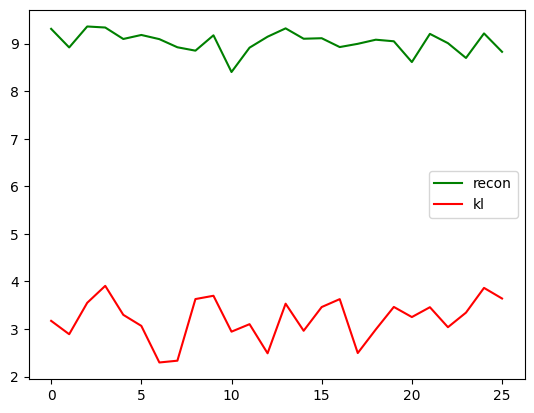

  1%|          | 26/2308 [00:07<11:32,  3.30it/s]


KeyboardInterrupt: 

In [22]:
train(net, train_loader, optimizer, 10)